<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="./211_ltpy_AC_SAF_GOME-2_l2_load_browse.ipynb"><< 211 - AC SAF - GOME-2 - Level 2 - Load and browse</a><span style="float:right;"><a href="./213_ltpy_IASI_L2_load_browse.ipynb">213 - IASI - Level 2 - Load and browse >></a></span>

# 2.1.2 AC SAF - GOME-2 - Level 2 - Pre-processing

The previous module [2.1.1](./211_ltpy_AC_SAF_GOME-2_L2_load_browse.ipynb) showed how AC SAF GOME-2 Level 2 data can be loaded and visualized. Unfiltered AC SAF GOME-2 Level 2 data may contain negative values and measurements can further be influenced by clouds. Thus, there are some pre-processing steps required to mask the data and filter invalid ground pixels. 

This module shows how AC SAF GOME-2 Level 2 data can be masked, how data from Metop-A and Metop-B can be combined and how a geographical subset can be selected.

Find more information in the [GOME-2 NO2 (and other trace gases) Product User guides](https://acsaf.org/docs/pum/Product_User_Manual_NTO_OTO_DR_GDP48_Jun_2017.pdf).

#### This module has the following outline:
* [1 - Data masking](#masking)
* [2 - Combine Metop-A and Metop-B data files](#metop_ab)
* [3 - Select geographical subset](#subset)

#### Load required libraries

In [1]:
import os
from netCDF4 import Dataset
import xarray as xr
import numpy as np

# Python libraries for visualisation
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from IPython.display import display, clear_output

#### Load helper functions

In [2]:
from ipynb.fs.full.ltpy_functions import load_l2_data_xr, visualize_gome_mollweide, visualize_l2

<hr>

### Load multi-file `DataArray`

In [3]:
directory_2a = './eodata/gome2/offline/2a//2019/08/18/'
no2_a_da_mf = load_l2_data_xr(directory_2a, 'TOTAL_COLUMNS', 'NO2Tropo', 'LatitudeCentre', 'LongitudeCentre', 1, longname='Tropospheric column density of NO2', unit='mol/cm\u00b2')
no2_a_da_mf

<xarray.DataArray 'NO2Tropo' (ground_pixel: 223224)>
array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 63.87075 64.20003 ... -61.54535 -62.054047
    longitude  (ground_pixel) float32 90.22523 89.898026 ... 29.047194 30.302885
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric column density of NO2
    units:      mol/cm²

## <a id="masking"></a>Data masking

AC SAF GOME-2 Level 2 data provide valuable information on the quality and validity of the measured data. Different conditions can influence the measured values:
* Negative values can occur, which are not valid
* Cloud fractions influence the measured values and lead to errors, and
* other conditions that might make the measured data invalid, e.g. an unsuccessful fitting of the slant column.

Thus, you have to mask the ground pixels that are valid.

### Flag negative values

Negative values can be flagged by casting the `DataArray` for only positive values.

In [4]:
no2_a_da_mf_flagged = no2_a_da_mf[no2_a_da_mf > 0]

print(no2_a_da_mf_flagged, no2_a_da_mf_flagged.min())

<xarray.DataArray 'NO2Tropo' (ground_pixel: 50266)>
array([1.247294e+14, 1.139597e+14, 4.416499e+14, ..., 2.402561e+14,
       1.403990e+15, 2.141181e+15], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 69.88291 69.26147 ... -51.51209 -51.51849
    longitude  (ground_pixel) float32 315.29028 314.26102 ... 36.779797 36.74854
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric column density of NO2
    units:      mol/cm² <xarray.DataArray 'NO2Tropo' ()>
array(5.099747e+10, dtype=float32)


<br>

You see that the minimum of our `DataArray` is not negative anymore. Visualizing the `DataArray` shows a more detailed representation of the total column NO<sub>2</sub>. Filtering just the negative values is only one part. Another important part to filter invalid pixels is to mask all ground pixels that are disturbed by clouds.

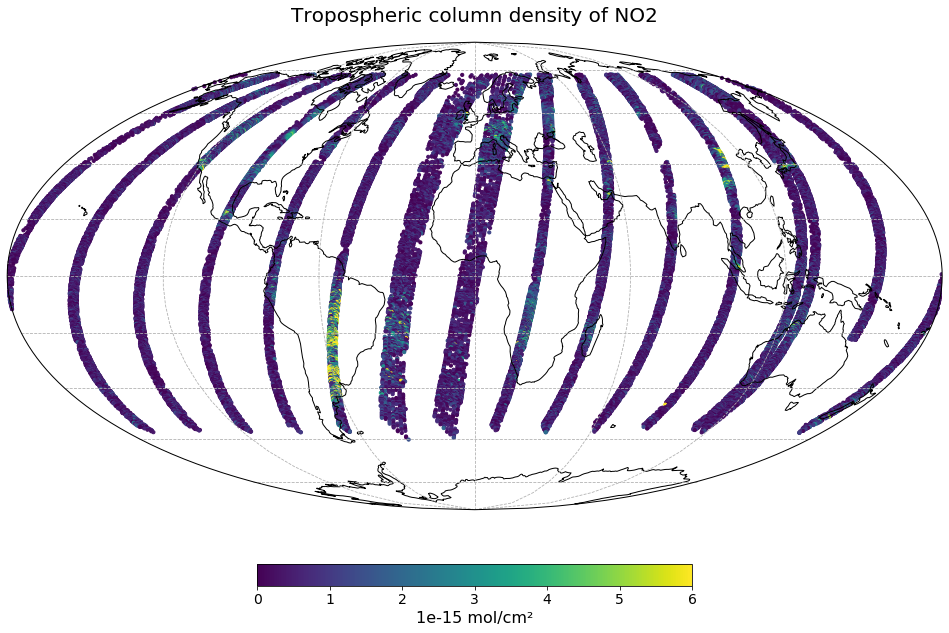

In [6]:
visualize_gome_mollweide(no2_a_da_mf_flagged, 1e-15, 'viridis', 10, vmin=0, vmax=6)

### Cloud masking

AC SAF GOME-2 Level 2 data provide under the groupd `CLOUD_PROPERTIES` information on the `CloudFraction` for each ground pixel. The first step is to generate a cloud mask you can apply to your total column data array. To start, you should load the cloud fraction property with the `load_l2_data_xr` function.

In [7]:
cloud_fraction_2a = load_l2_data_xr(directory_2a, 'CLOUD_PROPERTIES', 'CloudFraction', 'LatitudeCentre', 'LongitudeCentre', 1, unit='-', longname='Cloud Fraction')
cloud_fraction_2a

<xarray.DataArray 'CloudFraction' (ground_pixel: 223224)>
array([0.576101, 0.601783, 0.620129, ..., 1.      , 1.      , 0.920525],
      dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 63.87075 64.20003 ... -61.54535 -62.054047
    longitude  (ground_pixel) float32 90.22523 89.898026 ... 29.047194 30.302885
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Cloud Fraction
    units:      -

<br>

With xarray's function `where`, you can generate a cloud mask, by specifying e.g. each ground pixel with a `CloudFraction` higher than 50% to classify as unvalid (mask value = 0). The resulting mask has value 1 for ground pixels you want to keep and value 0 for ground pixels you want to drop. Xarray's `where` function further helps to apply the cloud mask to your `DataArray`. You want to keep the ground pixels where the cloud mask is 1 and we want to drop the rest.

The function [generate_masked_array](./ltpy_functions.ipynb#generate_masked_array) combines all steps of `cloud masking`. The masked array, where negative values were filtered out, is returned. You see that the number of valid ground pixels decreased from over 200 000 to less than 51 000.

In [10]:
def generate_masked_array(xarray, mask, threshold, operator):
    """ 
    Applies a cloud mask (e.g. cloud fraction values) onto a given data array, based on a given threshold.
    
    Parameters:
        xarray: a three-dimensional xarray DataArray object
        mask: 1-dimensional xarray DataArray, e.g. cloud fraction values
        threshold (float): any number between 0 and 1, specifying the degree of cloudiness which is acceptable.
        
    Returns:
        Masked xarray DataArray with flagged negative values
    """
    if(operator=='<'):
        cloud_mask = xr.where(mask < threshold, 1, 0) #Generate cloud mask with value 1 for the pixels we want to keep
    else:
        cloud_mask = xr.where(mask == threshold, 1, 0)
    xarray_masked = xr.where(cloud_mask ==1, xarray, 0) #Apply mask onto the DataArray
    xarray_masked.attrs = xarray.attrs #Set DataArray attributes 
    return xarray_masked[xarray_masked > 0] #Return masked DataArray and flag negative values

In [11]:
no2_a_da_masked = generate_masked_array(no2_a_da_mf, cloud_fraction_2a, 0.5, '<')
no2_a_da_masked

<xarray.DataArray (ground_pixel: 50264)>
array([1.247294e+14, 1.139597e+14, 4.416499e+14, ..., 2.402561e+14,
       1.403990e+15, 2.141181e+15], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 69.88291 69.26147 ... -51.51209 -51.51849
    longitude  (ground_pixel) float32 315.29028 314.26102 ... 36.779797 36.74854
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric column density of NO2
    units:      mol/cm²

<br>

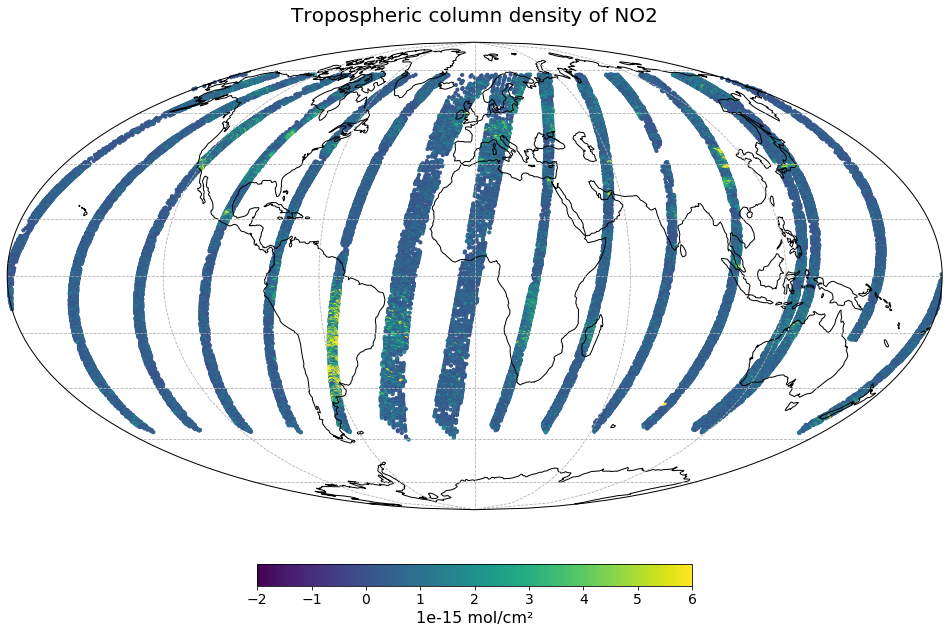

In [12]:
visualize_gome_mollweide(no2_a_da_masked, 1e-15, 'viridis', 10, vmin=-2, vmax=6)

<br>

## <a id="metop_ab"></a>Combine Metop-A and Metop-B data files

The above examples show that Metop-A data have many parts on Earth unsensed. Metop-A data can be combined with Metop-B ground pixels for one specific day to increase the overall coverage. Metop-B has a wider nominal resolution than Metop-A.

Since you already concatenated and filtered the ground pixel values for day 18 Aug 2019 for Metop-A GOME Level 2 data, you only have to repeat the same pre-processing steps for the Metop-B data files:

1. Load total column of tropospheric NO<sub>2</sub> values with `load_l2_data_xr` function 
2. Load cloud fraction information with `load_l2_data_xr` function
3. Filter unvalid ground pixels with `generate_masked_array`
4. Visualize the masked array with `visualize_gome_mollweide`.

#### 1. Load total column NO<sub>2</sub> values from MetOp-B

In [13]:
directory_2b= './eodata/gome2/offline/2b/2019/08/18/'
no2_b_da_mf = load_l2_data_xr(directory_2b, 'TOTAL_COLUMNS', 'NO2Tropo', 'LatitudeCentre', 'LongitudeCentre', 1, longname='Tropospheric column density of NO2', unit='mol/cm\u00b2')
no2_b_da_mf

<xarray.DataArray 'NO2Tropo' (ground_pixel: 211316)>
array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 62.95204 63.251656 ... -68.07183
    longitude  (ground_pixel) float32 193.75484 193.30927 ... 158.388 158.22429
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric column density of NO2
    units:      mol/cm²

<br>

#### 2. Load cloud fraction information

In [14]:
cloud_fraction_2b = load_l2_data_xr(directory_2b,'CLOUD_PROPERTIES','CloudFraction', 'LatitudeCentre', 'LongitudeCentre', 1,unit='-', longname='Cloud Fraction') 
cloud_fraction_2b

<xarray.DataArray 'CloudFraction' (ground_pixel: 211316)>
array([0.856058, 0.859357, 0.852944, ..., 0.663486, 0.660541, 0.661271],
      dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 62.95204 63.251656 ... -68.07183
    longitude  (ground_pixel) float32 193.75484 193.30927 ... 158.388 158.22429
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Cloud Fraction
    units:      -

<br>

#### 3. Mask data array

In [15]:
no2_b_da_masked = generate_masked_array(no2_b_da_mf, cloud_fraction_2b, 0.5, '<')
no2_b_da_masked

<xarray.DataArray (ground_pixel: 45052)>
array([5.511362e+14, 2.997801e+13, 3.909374e+14, ..., 2.549248e+14,
       3.118841e+14, 1.082397e+14], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 69.97122 69.344376 ... -59.068363
    longitude  (ground_pixel) float32 99.48988 86.42549 ... 162.28395 161.9735
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric column density of NO2
    units:      mol/cm²

<br>

#### 4. Visualization of masked MetOp-B Total column NO2 ground pixels

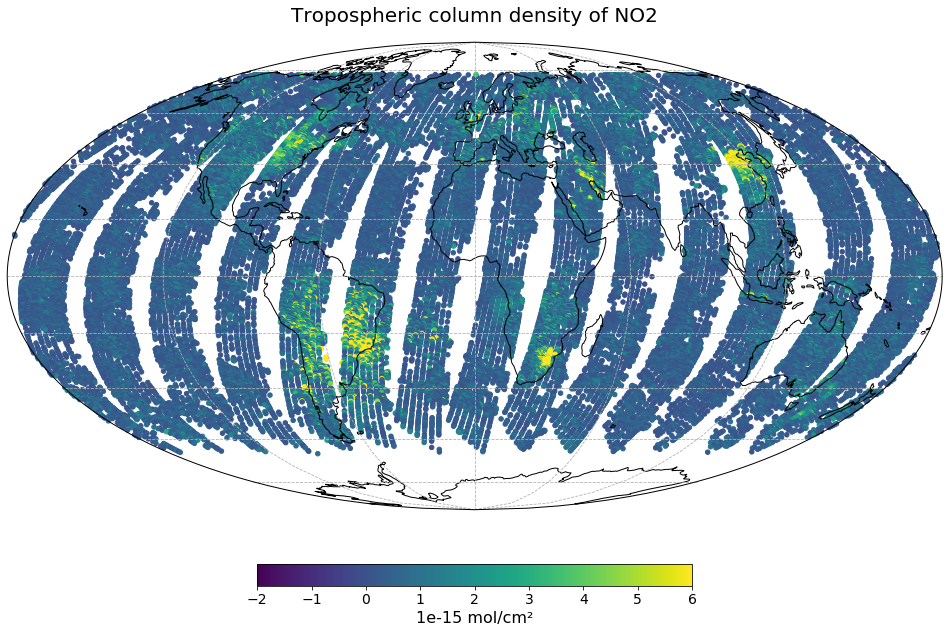

In [17]:
visualize_gome_mollweide(no2_b_da_masked, 1e-15, 'viridis', 10, vmin=-2, vmax=6)

<br>

### Combine masked `DataArrays` with `xarray.concat`

To combine data from Metop-A and Metop-B, you have to concatenate both `DataArrays` with `xarray.concat`. The resulting `DataArray` object has more than 95,000 ground pixel values. With the `visualize_gome_mollweide` function, you can visualize the combined `DataArray`.

In [18]:
no2_ab_da_masked = xr.concat([no2_a_da_masked, no2_b_da_masked], dim='ground_pixel')
no2_ab_da_masked

<xarray.DataArray (ground_pixel: 95316)>
array([1.247294e+14, 1.139597e+14, 4.416499e+14, ..., 2.549248e+14,
       3.118841e+14, 1.082397e+14], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 69.88291 69.26147 ... -59.068363
    longitude  (ground_pixel) float32 315.29028 314.26102 ... 162.28395 161.9735
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric column density of NO2
    units:      mol/cm²

<br>

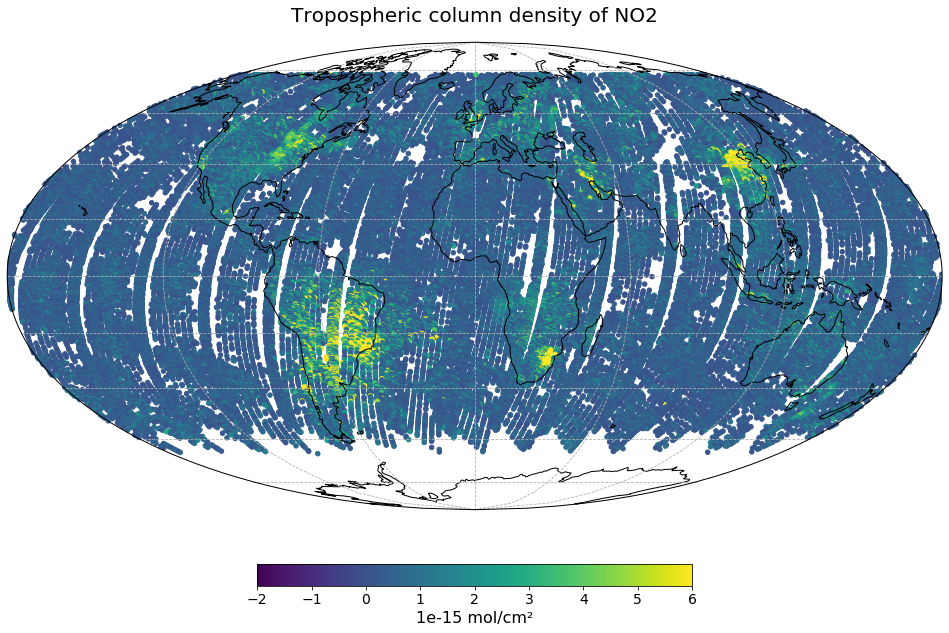

In [19]:
visualize_gome_mollweide(no2_ab_da_masked, 1e-15, 'viridis', 10, vmin=-2, vmax=6)

<br>

## <a id="subset"></a>Select geographical subset

You can generate a `geographical subset` of the `DataArray` to get a closer look at one specific region. The subset can easily be created with xarray's function `where`. We can assign for `latitude` and `longitude` a minimum and maximum threshold. By using the `drop` argument, we drop the data values for which the condition is False.

There is one caveat: the `longitude` values of the AC SAF GOME-2 Level 2 data are stored as 0 to 360-degrees longitudes. Thus, if you want to select the geographical subset based on a geographical bounding box of -180 to 180 degrees, you have to convert the `longitude` values first. This is done by assigning the `longitude` values with the `assign_coords` function.

In [20]:
no2_ab_da_masked = no2_ab_da_masked.assign_coords(longitude=(((no2_ab_da_masked.longitude + 180) % 360) - 180))

#### Select the bounding box with xarray's `where` function

Let's select a bounding box over South America and parts of Central and Southern Africa with the following latitude and longitude boundaries:
* `latitude`: -60 deg to 15 deg
* `longitude`: -80 deg to 40 deg

In [21]:
no2_ab_da_subset = no2_ab_da_masked.where((no2_ab_da_masked.latitude < 15) & (no2_ab_da_masked.latitude > -60) & (no2_ab_da_masked.longitude < 40) & (no2_ab_da_masked.longitude > -80),drop=True)
no2_ab_da_subset

<xarray.DataArray (ground_pixel: 15813)>
array([6.542625e+14, 9.530239e+14, 3.062013e+14, ..., 2.138452e+13,
       6.013099e+14, 2.324516e+14], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 14.973023 14.907713 ... -59.1313
    longitude  (ground_pixel) float32 -73.150604 -72.91504 ... -20.667236
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric column density of NO2
    units:      mol/cm²

<br>

You can now visualize the geographic subset with the defined function `visualize_gome_l2`, which represents the subset in a `PlateCarree` projection.

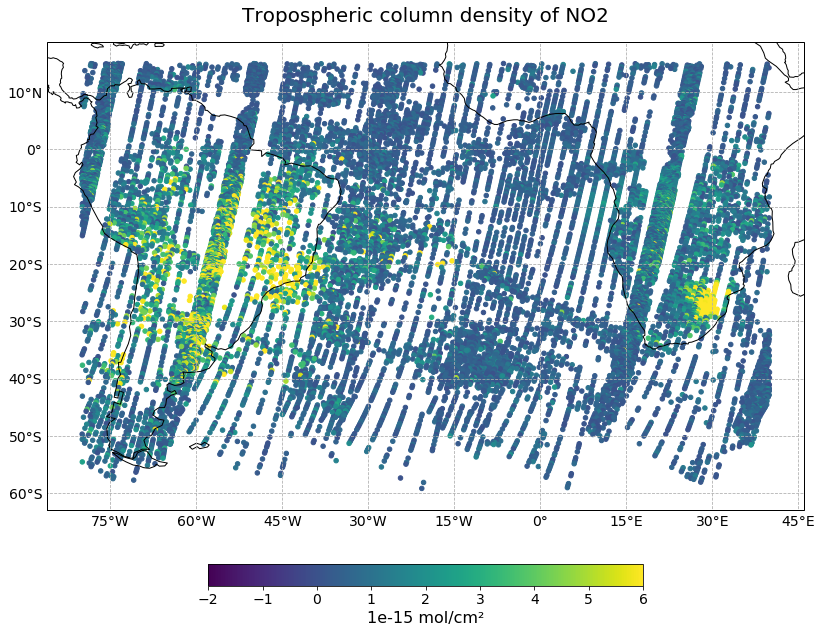

In [24]:
visualize_l2(no2_ab_da_subset, 1e-15, ccrs.PlateCarree(), vmin=-2,vmax=6, point_size=20,color_scale='viridis', unit=no2_ab_da_subset.units, title=no2_ab_da_subset.long_name, set_global=False)

<br>

<a href="./211_ltpy_AC_SAF_GOME-2_l2_load_browse.ipynb"><< 211 - AC SAF - GOME-2 - Level 2 - Load and browse</a><span style="float:right;"><a href="./213_ltpy_IASI_L2_load_browse.ipynb">213 - IASI - Level 2 - Load and browse >></a></span>

<hr>

<p style="text-align:left;">This project is licensed under the <a href="./LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eo-lab/training-atmospheric-composition/">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:training@eumetsat.int>Contact</a></span></p>